In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from tqdm import tqdm
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from datetime import datetime
from torchvision import models
#from transformers import CLIPProcessor, CLIPModel
import os
import csv
from peft import LoraConfig, get_peft_model
import json

import pandas as pd
import os
import random
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv

import transformers
from transformers import CLIPProcessor, CLIPModel
from multilingual_clip import pt_multilingual_clip # Note: add device parameter to forward manually
import open_clip

import psycopg2

from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


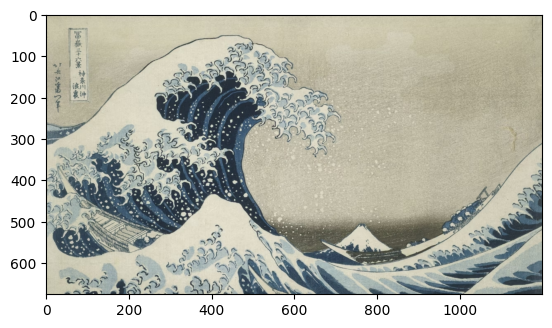

In [3]:
import matplotlib.pyplot as plt
example_text = "A photo of a cat"
example_image = Image.open("Hokusai_Great-Wave.jpg")
plt.imshow(example_image)
plt.show()

In [ ]:
# List clip models
model_names = {
    "art-mini": "openai/clip-vit-base-patch32",
    "art-base": "openai/clip-vit-large-patch14",
    "art-large": "openai/clip-vit-large-patch14-336",
}
def get_stats(model_name):
    processor = CLIPProcessor.from_pretrained(model_name)
    model = CLIPModel.from_pretrained(model_name).to(device)
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

    nb_params = sum(p.numel() for p in model.parameters())

    # Encode the example image and text to get the resolution it resized to
    inputs = processor(images=example_image, text=example_text, return_tensors="pt").to(device)

    # Embed the example image
    image_features = model.get_image_features(
        pixel_values=inputs["pixel_values"],
        interpolate_pos_encoding=False
    )
    image_feature_resolution = image_features.shape

    # Embed the example text
    image_text = processor(text=example_text, return_tensors="pt").to(device)
    image_text_features = model.get_text_features(**image_text)
    image_text_feature_resolution = image_text_features.shape

    # Get the maximum number of tokens in the text encoder
    max_tokens = model.text_model.config.max_position_embeddings

    # Get the output shape
    outputs = model.forward(**inputs)
    text_dim = outputs.text_embeds
    img_dim = outputs.image_embeds

    # Measure the time it takes to use model.forward() on a batch of 2
    start_time = time.time()
    inputs = processor(images=[example_image] * 2, text=[example_text] * 2, return_tensors="pt").to(device)
    model.forward(**inputs)
    end_time = time.time()
    forward_time = end_time - start_time

    del model, processor, tokenizer

    return {
        "nb_params": nb_params,
        "image_feature_resolution": image_feature_resolution,
        "image_text_feature_resolution": image_text_feature_resolution,
        "max_tokens": max_tokens,
        "text_dim": text_dim.shape,
        "img_dim": img_dim.shape,
        "forward_time": forward_time
    }

stats = {}
for model_name in model_names:
    base_model = model_names[model_name]
    print("model_name: ", model_name)
    stats[model_name] = get_stats(base_model)
    print("")

stats["art-mini"]["resolution"] = "224x224"
stats["art-base"]["resolution"] = "224x224"
stats["art-large"]["resolution"] = "336x336"


model_name:  art-mini

model_name:  art-base

model_name:  art-large



In [5]:
# Save stats to json
with open("stats.json", "w") as f:
    json.dump(stats, f)

In [6]:
for model_name in stats:
    print(model_name)
    for key, value in stats[model_name].items():
        print(f"    > {key}: {value}")
    print("")


art-mini
    > nb_params: 151277313
    > image_feature_resolution: torch.Size([1, 512])
    > image_text_feature_resolution: torch.Size([1, 512])
    > max_tokens: 77
    > text_dim: torch.Size([1, 512])
    > img_dim: torch.Size([1, 512])
    > forward_time: 0.03749966621398926

art-base
    > nb_params: 427616513
    > image_feature_resolution: torch.Size([1, 768])
    > image_text_feature_resolution: torch.Size([1, 768])
    > max_tokens: 77
    > text_dim: torch.Size([1, 768])
    > img_dim: torch.Size([1, 768])
    > forward_time: 0.05350065231323242

art-large
    > nb_params: 427944193
    > image_feature_resolution: torch.Size([1, 768])
    > image_text_feature_resolution: torch.Size([1, 768])
    > max_tokens: 77
    > text_dim: torch.Size([1, 768])
    > img_dim: torch.Size([1, 768])
    > forward_time: 0.09549903869628906

